In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
from splot import esda as esdaplot
from matplotlib.colors import LogNorm
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pointpats
from pointpats import distance_statistics, QStatistic, random, PointPattern
from tqdm import tqdm

In [2]:
population = pd.read_csv('../output/preprocessing/preprocessing_population.csv')
population_gdf = gpd.GeoDataFrame(population, crs='EPSG:7855', geometry=gpd.GeoSeries.from_wkt(population['geometry']))

In [6]:
population_gdf['Pop_density_2021_people_per_km2'] = population_gdf['ERP_2021'] / population_gdf['Area_km2']

In [10]:
boundary = gpd.read_file('../data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
boundary = boundary[boundary['GCC_NAME21'] == 'Greater Melbourne']
boundary['geometry'] = boundary['geometry'].to_crs('EPSG:7855')

In [11]:
hospital = pd.read_csv('../output/preprocessing/non-residential_facilities/hospitals_GreaterMelbourne.csv')
hospital_gdf = gpd.GeoDataFrame(hospital, crs='EPSG:7855', geometry=gpd.GeoSeries.from_wkt(hospital['geometry']))
joined_hospital = gpd.sjoin(hospital_gdf, boundary, how='inner', op='within')
point_counts_hospital = joined_hospital.groupby('index_right').size()
boundary['point_count_hospital'] = point_counts_hospital
boundary['point_count_hospital'] = boundary['point_count_hospital'].fillna(0)


schools = pd.read_csv('../output/preprocessing/non-residential_facilities/schools_GreaterMelbourne.csv')
schools_gdf = gpd.GeoDataFrame(schools, crs='EPSG:7855', geometry=gpd.GeoSeries.from_wkt(schools['geometry']))
joined_schools = gpd.sjoin(schools_gdf, boundary, how='inner', op='within')
point_counts_school = joined_schools.groupby('index_right').size()
boundary['point_count_school'] = point_counts_school
boundary['point_count_school'] = boundary['point_count_school'].fillna(0)

shopping = pd.read_csv('../output/preprocessing/non-residential_facilities/shopping_GreaterMelbourne.csv')
shopping_gdf = gpd.GeoDataFrame(shopping, crs='EPSG:7855', geometry=gpd.GeoSeries.from_wkt(shopping['geometry']))
joined_shopping = gpd.sjoin(shopping_gdf, boundary, how='inner', op='within')
point_counts_shopping = joined_shopping.groupby('index_right').size()
boundary['point_count_shopping'] = point_counts_shopping
boundary['point_count_shopping'] = boundary['point_count_shopping'].fillna(0)


sports = pd.read_csv('../output/preprocessing/non-residential_facilities/sport_GreaterMelbourne.csv')
sports_gdf = gpd.GeoDataFrame(sports, crs='EPSG:7855', geometry=gpd.GeoSeries.from_wkt(sports['geometry']))
joined_sports = gpd.sjoin(sports_gdf, boundary, how='inner', op='within')
point_counts_sports = joined_shopping.groupby('index_right').size()
boundary['point_count_sports'] = point_counts_sports
boundary['point_count_sports'] = boundary['point_count_sports'].fillna(0)

In [22]:
def plot_K_function(gdfs):
    f, axs = plt.subplots(2,2, figsize=(12, 12))
    axs = axs.flatten()
    for i in range(len(gdfs)):
        coordinates = list()
        print(i)
        for index, row in tqdm(gdfs[i].iterrows()):
            # coordinates.append((row.lon, row.lat))
            coordinates.append((row.geometry.x, row.geometry.y))
        coordinate_array = np.array(coordinates)
        k_point_pattern = pointpats.k_test(coordinate_array, support = 1000, keep_simulations = True, n_simulations = 999)        
        ax = axs[i]
        ax.plot(k_point_pattern.support, k_point_pattern.statistic, 
         color='orangered', label='Observed - Spatial Pattern')
        ax.plot(k_point_pattern.support, np.mean(k_point_pattern.simulations, axis=0), 
         color='b', label = 'Expected - Random Spatial Pattern')
        ax.legend()
        ax.axis('on')
        ax.set_xlabel('Distance (m)', fontsize=12)
        ax.set_ylabel('K function', fontsize=12)
        ax.set_title('Ripley\'s K Function', fontsize=12)
    plt.plot()
        

0


130it [00:00, 21670.82it/s]

1


1405it [00:00, 21282.81it/s]


2


179it [00:00, 11187.64it/s]


3


2198it [00:00, 25255.68it/s]


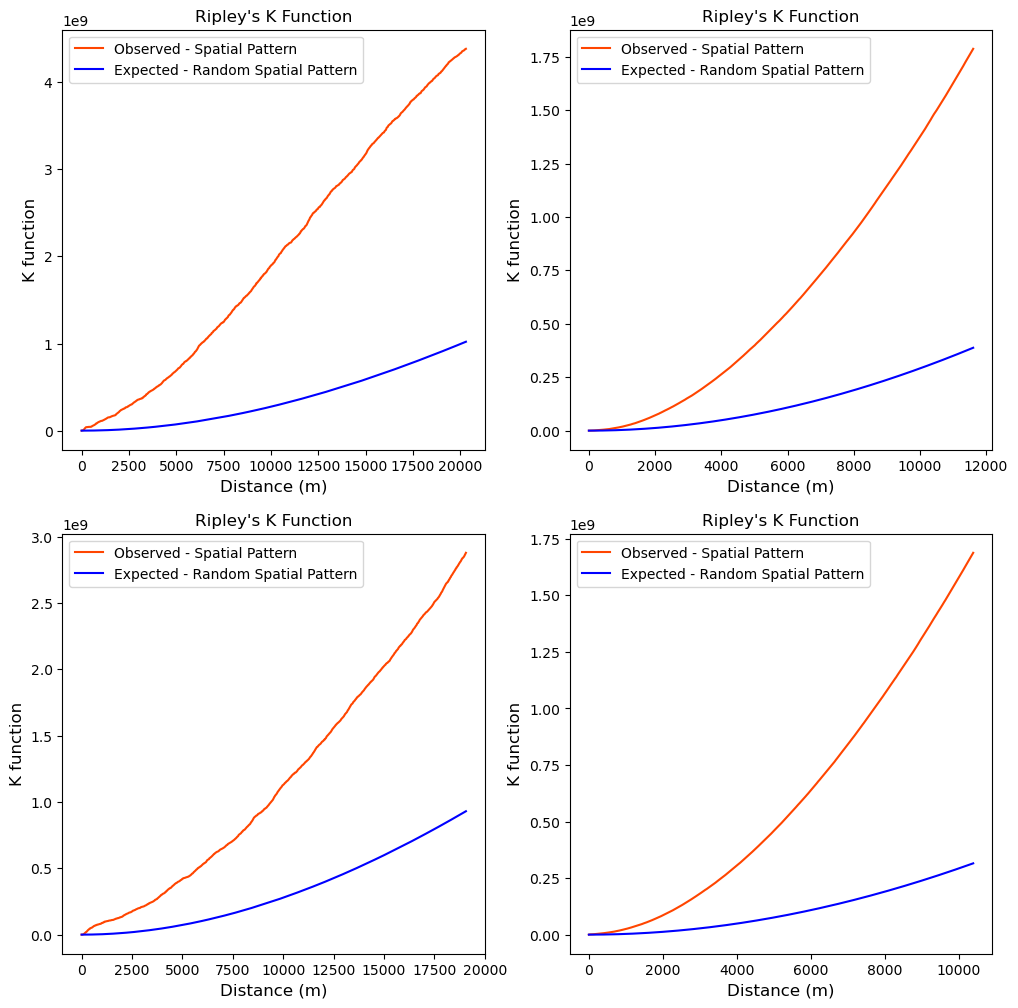

In [23]:
plot_K_function([hospital_gdf, schools_gdf, shopping_gdf, sports_gdf])

In [18]:
def plot_LISA(gdfs, cols, titles):
    f, axs = plt.subplots(2,2, figsize=(12, 12))
    # Make the axes accessible with single indexing
    axs = axs.flatten()

    for i in range(len(gdfs)):
        w = weights.KNN.from_dataframe(gdfs[i], k = 5)
        w.transform = "R"
        lisa = esda.moran.Moran_Local(gdfs[i][cols[i]], w)
        ax = axs[i]
        esdaplot.lisa_cluster(lisa, gdfs[i], p=0.05,ax = ax)
        ax.axis('on')

        ax.set_title(f"Moran Cluster Map: {titles[i]}")
        ax.set_xlabel('Easting', fontsize = 12)  # Set x-axis label
        ax.set_ylabel('Northing', fontsize = 12)  # Set y-axis label
    plt.plot()

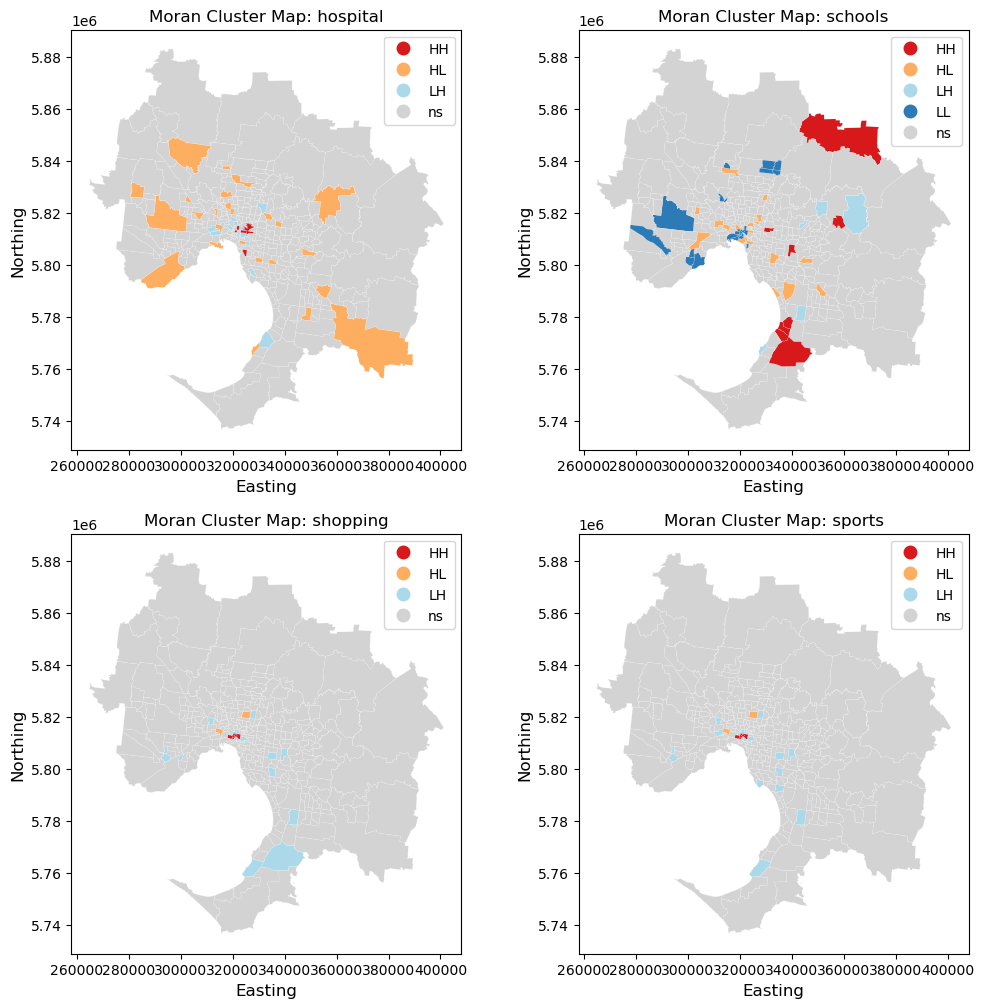

In [19]:
gdfs = [boundary, boundary, boundary, boundary]
columns = ['point_count_hospital', 'point_count_school', 'point_count_shopping', 'point_count_sports']
titles = ['hospital', 'schools', 'shopping', 'sports']
plot_LISA(gdfs, columns, titles)